## Standard Imports

Below we import the modules that we will be using for this analysis.

In [3]:
import datetime as dt
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Data acquisition

The first step is acquiring the data that we will be using for this analysis. There are two APIs that we use. The first API is the Pagecount API, which is a legacy API. Unfortunately, it doesn't allow us to differentiate between views caused by crawlers vs those caused by actually users.

The second API that we use is the Pageviews API. This API has more freedom, allowing us to acquire data with a much better level of granularity as compared to the Pagecount API. We can choose to get data on views caused by actual visitors, and not those caused by crawlers. The procedure is the same for both, we send a set of parameters to the API, and get back a response JSON object.

In [139]:
# First define the endpoints. We use two APIs to 
# acquire the data, the legacy and the pageviews API

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/\
                  metrics/legacy/pagecounts/aggregate/\
                  {project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

We first access the data from the legacy pagecounts API and save it as two seperate JSON files. One JSON contains the data for desktop views, and the other contains data for mobile views.

In [39]:
# The end_date is the last date for which the pagecounts
# API provides data. The pageviews API replaced the pagecounts
# API.
end_date = '2016073100' 

# The date when the API was created.
start_date = '2008010100' 

We need two accesses. One for the legacy pagecount desktop site traffic and one for the mobile site traffic. 

In [48]:
# Define the parameter dictionary that contains the 
# parameters that need to be sent to the API

params = {'project' : 'en.wikipedia.org',
            'access-site' : 'desktop-site',
            'granularity' : 'monthly',
            'start' : '2008070100',
            'end' : '2016080100'
            }

Perform the API call for desktop site data, and save it as a JSON.

In [50]:
# Getting desktop-data from the legacy API
api_call = requests.get(endpoint.format(**params))
response = api_call.json()

# Writing JSON data to a file
fileName= open('pagecounts_desktop-site_200801-201607.json', 'w')
json.dump(response, fileName, indent = 4)
fileName.close()

Perform the API call for mobile site data, and save it as a JSON.

In [51]:
# Getting mobile-site traffic data from the API
params['access-site'] = 'mobile-site'
api_call = requests.get(endpoint.format(**params))
response = api_call.json()

# Writing JSON data to a file
fileName= open('pagecounts_mobile-site_200801-201607.json', 'w')
json.dump(response, fileName, indent = 4)
fileName.close()

The next step is getting the data from the newer, more versatile Pageviews API. The pageviews API allows us to filter out data from spiders and only get traffic from actual users. It also allows us to get data for both mobile app views and mobile browser views. This isn't of any particular interest to us in this case, since we coalesce these two together.

In [70]:
# Define the parameters dictionary that will be passed 
# to the API

params = {'project' : 'en.wikipedia.org',
            'access' : 'desktop',
            'agent' : 'user',
            'granularity' : 'monthly',
            'start' : '2015070100',
            'end' : '2018100100'
            }

headers = {
    'User-Agent': 'https://github.com/tejasmhos',
    'From': 'tejash@uw.edu'
}

In [71]:
# Getting Desktop traffic data from Pageviews
api_call = requests.get(endpoint_pageviews.format(**params))
response = api_call.json()
fileName= open('pageviews_desktop_201507-201810.json', 'w')
json.dump(response, fileName, indent = 4)
fileName.close()

In [72]:
# Getting Mobile-App traffic data from Pageviews API
params['access'] = 'mobile-app'
api_call = requests.get(endpoint_pageviews.format(**params))
response = api_call.json()
fileName= open('pageviews_mobile-app_201507-201810.json', 'w')
json.dump(response, fileName, indent = 4)
fileName.close()

In [73]:
# Getting Mobile-web traffic data from Pageviews API
params['access'] = 'mobile-web'
api_call = requests.get(endpoint_pageviews.format(**params))
response = api_call.json()
fileName= open('pageviews_mobile-web_201507-201810.json', 'w')
json.dump(response, fileName, indent = 4)
fileName.close()

## Step 2: Data Processing

The data that we have acquired above contains the information that we need. However, it is not in the format that we require it to be in. The data has to processed so that it can be outputted to a CSV file that is going to be saved on the file system. 

My process is simple. Firstly, the data JSON objects that we saved are loaded back into the notebook. We then convert these JSONs to dataframes, where the dataframes contain only relevant information. In this case, the date and the views. Then a function builds the dataset by merging each of these individual datasets together, substituting 0's where no value is present and then writing it to a CSV.

In [75]:
# Load all the data into the Notebook to make processing easier

with open('pagecounts_desktop-site_200801-201607.json') as json_data:
    pagecounts_desktop = json.load(json_data)

with open('pagecounts_mobile-site_200801-201607.json') as json_data:
    pagecounts_mobile = json.load(json_data)

with open('pageviews_desktop_201507-201810.json') as json_data:
    pageviews_desktop = json.load(json_data)

with open('pageviews_mobile-app_201507-201810.json') as json_data:
    pageviews_mobapp = json.load(json_data)

with open('pageviews_mobile-web_201507-201810.json') as json_data:
    pageviews_mobweb = json.load(json_data)

The function below just converts the JSON to a dataframe. It omits information that we no longer require, and makes it into an easily accessible and usable JSON file.

In [107]:
def json_to_dataframe(json_file, count_name):
    """
    This function converts the JSON dictionary object into
    a dataframe.
    """
    dates = []
    traffic = []
    for item in json_file['items']:
        dates.append(item['timestamp'])
        traffic.append(item['count'])
    return pd.DataFrame({'Date':dates, count_name:traffic})

We run the function above on the JSON objects that contain pagecount desktop and pagecount mobile data. This is converted into two dataframes that are subsequently used in the function below.

In [108]:
pagecounts_desktop_processed = json_to_dataframe(pagecounts_desktop,'pagecount_desktop_views')
pagecounts_mobile_processed = json_to_dataframe(pagecounts_mobile, 'pagecount_mobile_views')

In [109]:
def json_to_dataframe_pageviews(json_file, count_name):
    """
    Similar to the function above, although some column names have changed. 
    Hence code needs to be modified.
    """
    dates = []
    traffic = []
    for item in json_file['items']:
        dates.append(item['timestamp'])
        traffic.append(item['views'])
    return pd.DataFrame({'Date':dates, count_name:traffic})

Do to a naming difference, I develop a slightly different function that essentially performs the same task. This function is run on the data from the Pageviews API and is returned below.

In [110]:
pageviews_desktop_processed = json_to_dataframe_pageviews(pageviews_desktop,'pageview_desktop_views')
pageviews_mobapp_processed = json_to_dataframe_pageviews(pageviews_mobapp,'pageview_mobile1_views')
pageviews_mobweb_processed = json_to_dataframe_pageviews(pageviews_mobweb,'pageview_mobile2_views')

In [111]:
pageviews_mobapp_processed['pageview_mobile_views'] = pageviews_mobapp_processed['pageview_mobile1_views'] + pageviews_mobweb_processed['pageview_mobile2_views'] 

We only want the mobile views data, we do not require the granularity that is provided by the Pageviews API. So we add the mobile app views and mobile website views together to get a total mobile visits number.

In [114]:
pageviews_mobile_processed = pageviews_mobapp_processed[['Date','pageview_mobile_views']]

The function below builds our dataset by merging all these smaller dataframes together to get one large dataframe. It then writes it to a CSV.

In [121]:
def build_dataset(pagecount_desktop, pagecount_mobile, pageview_desktop, pageview_mobile):
    """
    This module combines all the processed data sources into a Pandas Dataframe
    and exports it to a CSV so that it can be used for analysis.
    """
    dataframe_temp1 = pagecount_desktop.merge(pagecount_mobile, on = 'Date', how = 'outer')
    dataframe_temp2 = pageview_desktop.merge(pageview_mobile, on = 'Date', how = 'outer')
    dataframe_temp3 = dataframe_temp1.merge(dataframe_temp2, on = 'Date', how = 'outer')
    dataframe = dataframe_temp3[['Date','pagecount_desktop_views', 'pagecount_mobile_views',
                                'pageview_desktop_views','pageview_mobile_views']]
    
    dataframe = dataframe.fillna(0)
    dataframe['year'] = dataframe.Date.apply(lambda x: x[:4])
    dataframe['month'] = dataframe.Date.apply(lambda x: x[4:6])
    dataframe['pagecount_all_views'] = dataframe['pagecount_desktop_views'] + dataframe['pagecount_mobile_views']
    dataframe['pageview_all_views'] = dataframe['pageview_desktop_views'] + dataframe['pageview_mobile_views']
    
    dataframe_to_return = dataframe[['year','month','pagecount_all_views','pagecount_desktop_views',
                                     'pagecount_mobile_views','pageview_all_views',
                                     'pageview_desktop_views','pageview_mobile_views']]
    dataframe_to_return.to_csv('en-wikipedia_traffic_200801-201809.csv')
    

In [122]:
build_dataset(pagecounts_desktop_processed, pagecounts_mobile_processed, pageviews_desktop_processed, pageviews_mobile_processed)

# Step 3: Data Visualization

The main goal of this project is visualizing the visits data from various sources over a period of time. We want to do this on a month to month basis. We import the CSV that we saved above and use it to draw our plots.

In [140]:
data_to_plot = pd.read_csv('en-wikipedia_traffic_200801-201809.csv')

# Tell Pandas to use date as an actual date
data_to_plot['date'] = data_to_plot['year'].astype(str) + '-' + data_to_plot['month'].astype(str) + '-01'
data_to_plot['date'] = pd.to_datetime(data_to_plot['date'], format ='%Y-%m-%d')

# Remove redundant lines corresponding to 0 values
data_to_plot.replace(0, float('nan'), inplace=True)

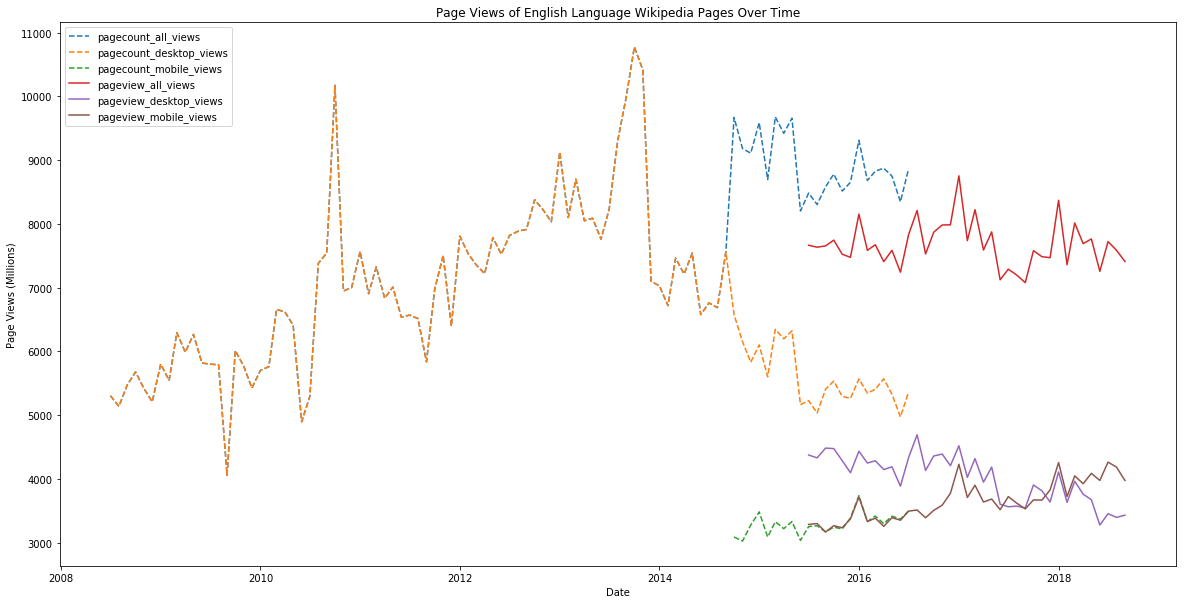

In [141]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(data_to_plot['date'],data_to_plot['pagecount_all_views']/1e6, '--')
plt.plot(data_to_plot['date'],data_to_plot['pagecount_desktop_views']/1e6, '--')
plt.plot(data_to_plot['date'],data_to_plot['pagecount_mobile_views']/1e6, '--')
plt.plot(data_to_plot['date'],data_to_plot['pageview_all_views']/1e6)
plt.plot(data_to_plot['date'],data_to_plot['pageview_desktop_views']/1e6)
plt.plot(data_to_plot['date'],data_to_plot['pageview_mobile_views']/1e6)
plt.legend(loc='upper left')
plt.xlabel('Date')  
plt.ylabel('Page Views (Millions)')  
plt.title('Page Views of English Language Wikipedia Pages Over Time')  

plt.savefig('visualizing_page_views.png')
plt.show()

The plot above visualizes our data. It is also saved as a file to our filesystem for further usage.